<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/signal/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [19]:
# download example data
from google_drive_downloader import GoogleDriveDownloader

file_id = "1XP6VG6b42PZZzvmqskTpczq2uolPnoNF"

GoogleDriveDownloader.download_file_from_google_drive(
    file_id,
    "./example.zip",
    overwrite = True,
    unzip = True
)

file_id = "1SswOmiiZ93uILL3owl0N4YyXf9RtcRni"

GoogleDriveDownloader.download_file_from_google_drive(
    file_id,
    "./example_csv.zip",
    overwrite = True,
    unzip = True
)


Unzipping...Done.
Unzipping...Done.


In [21]:
# clone signal processing utils
!git clone \
--depth 1 \
https://github.com/AllanKamimura/AI.git

Cloning into 'AI'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 91 (delta 6), reused 67 (delta 2), pack-reused 0
Unpacking objects: 100% (91/91), done.
Checking out files: 100% (69/69), done.


In [22]:
from AI.signal.preprocessing import not_keras, my_utils
from AI.signal.models import layers

## Create Dataset
```
── [yourdataset]
        ├── class1
        │     ├── file1.mat
        │     ├── file2.mat
        │     └──  ...
        └── class2
             ├── file3.mat
             ├── file4.mat
             └──  ...
```

In [23]:
# converts the matlab files (saved signal matrix) to .TIF
# to save a matlab variable containing a matrix, use
# > save file_name.mat variable_name

import os

folders = os.listdir("/content/example")

for folder in folders:
    folder_path = os.path.join("/content/example", folder)
    my_utils.image_save(folder_path, mode = "matlab")

In [24]:
# converts the csv files (saved signal matrix) to .TIF
# to save a python variable containing a matrix as csv, use
# > np.savetxt("file_name.csv", variable_name, delimiter=",")

import os

folders = os.listdir("/content/example_csv")

for folder in folders:
    folder_path = os.path.join("/content/example_csv", folder)
    my_utils.image_save(folder_path, mode = "csv")

In [25]:
# the metadata dataframe contains 2 columns
# x_col: is the relative path to the images
# y_col: is the class label
# you can include extra cols such as "is_valid", to filter train/val split

import pandas as pd

df = pd.read_csv("./metadata.csv")
df.head()

,x_col,y_col
0,./class1_images/1.tif,class1
1,./class1_images/2.tif,class1
2,./class1_images/3.tif,class1
3,./class1_images/4.tif,class1
4,./class1_images/5.tif,class1


## TensorFlow Data Generator

In [26]:
# the problem with the standard iterator from keras is that
# it normalizes the data to be between 0:1

train_datagen = not_keras.DataFrameIterator(
    directory = "./example_csv", # root images directory
    dataframe = df,
    x_col = "x_col",
    y_col = "y_col",
    color_mode = "grayscale",
    target_size = (8000, 20), # (timesteps, channels)
    batch_size = 5,
    shuffle = True,
    validate_filenames = True,
    classes = ['class1', 'class2']
)

Found 10 validated image filenames belonging to 2 classes.


In [27]:
signals, labels = train_datagen.next()
print(labels)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


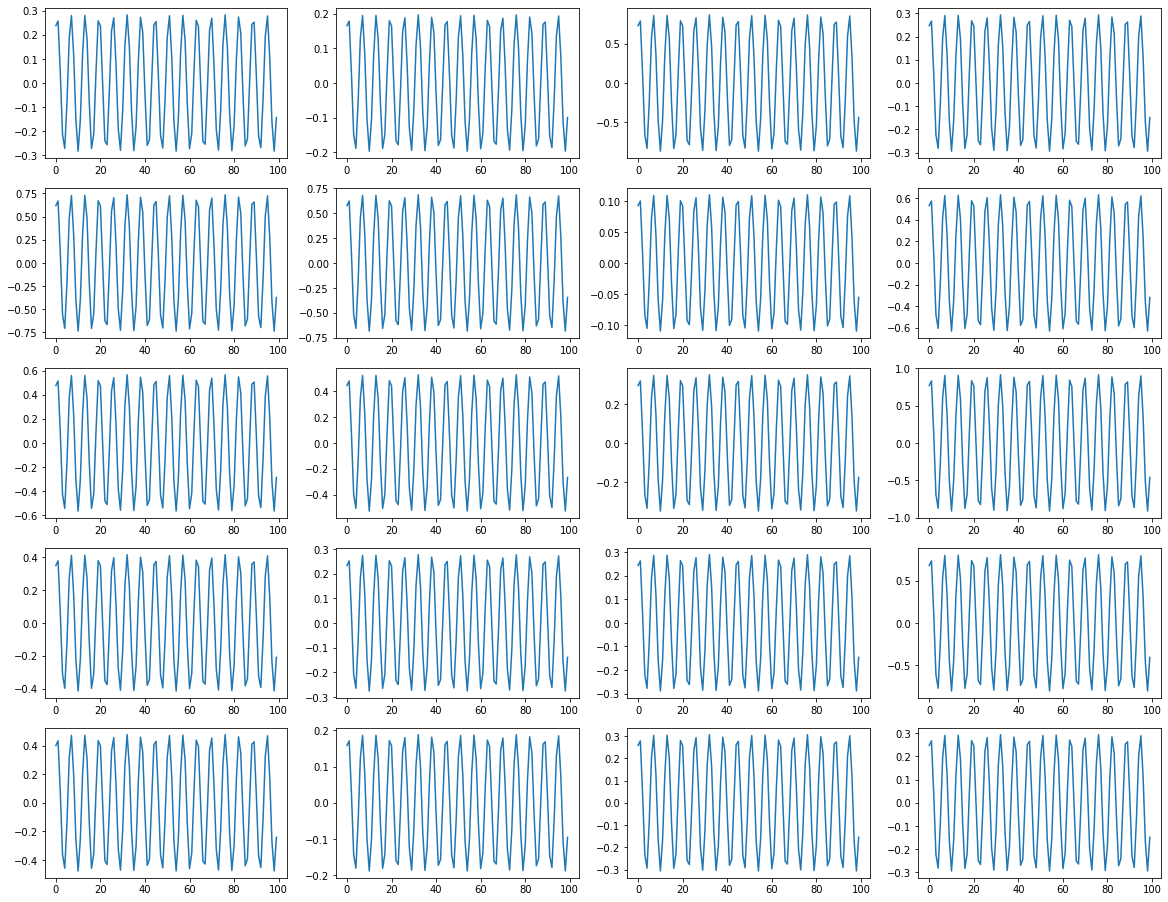

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,4,figsize = (20,16))

for i in range(20):
    row = i // 4
    col = i % 4

    ax[row, col].plot(np.squeeze(signals[0][:100,i]))

## Tensorflow Model

In [29]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [layers.MyInput(input_shape = (8000,20, 1)),
     tf.keras.layers.Conv1D(filters = 40, kernel_size = 5, strides = 2),
     tf.keras.layers.MaxPool1D(),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(1, activation = "sigmoid")]
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Functional)  (None, 8000, 20)          0         
                                                                 
 conv1d (Conv1D)             (None, 3998, 40)          4040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1999, 40)         0         
 )                                                               
                                                                 
 global_average_pooling1d (G  (None, 40)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainabl

In [30]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam"
)

In [31]:
model.fit(train_datagen)

2/2 [==============================] - 2s 50ms/step - loss: 0.6985
